In [2]:
# !wget http://visual.ic.uff.br/proeng/thiagoelias/database.rar

In [3]:
import os,glob
import numpy as np
import cv2
import glob
import pickle
import tensorflow as tf
import argparse
import re
import datetime
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,LeakyReLU,Add,Average,Lambda,MaxPool2D,Dropout,UpSampling2D,Concatenate,Multiply,GlobalAveragePooling2D,Dense,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import concatenate,Flatten,ConvLSTM2D,MaxPooling2D,ReLU,Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.feature import hog,local_binary_pattern
from skimage import data, exposure
from skimage.transform import radon, rescale
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature
tf.__version__


'2.18.0'

In [4]:
!pip install rarfile

In [6]:
os.listdir(os.getcwd())

['.config', 'database.rar', 'database', 'sample_data']

In [30]:
# prompt: It seems there is no code to extract the database.rar file I have uploaded. Please add code to extract data from the rar file using rarfile python package. I would prefer all extracted data to be in a folder of the same name of the file

import rarfile

# Assuming database.rar is in the current directory
try:
    rf = rarfile.RarFile("database.rar")
    rf.extractall(path="database") # extract to a folder named 'database'
    print("File extracted successfully!")
except rarfile.Error as e:
    print(f"Error extracting rar file: {e}")
except FileNotFoundError:
    print("database.rar not found in the current directory.")


File extracted successfully!


## Dataset Generation

- test path: `/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes`

- train path `/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia`



In [50]:
# prompt: we have two folders inside database. I want to use as train path the path /content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia and as test path the path /content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes. Inside each there are two folders DOENTES which will be cancerous and SAUDÁVEIS which will be healthy classification. Inside each of those folders there are subfolders numbered that are related to patient and inside each patient there are two folders Matrizes and Segmentadas. Matrices has .txt and Segmentadas has .png. Create a code that creates a list for healthy cases and for cancerous cases, each item of the list will be a touple where the first item must be the .png and the second item the .txt. please separate the cases because the sadaveis and doentes are not the same cases nor patients

import os
import glob

def create_dataset(path):
    healthy_cases = []
    cancerous_cases = []

    for condition in ['SAUDÁVEIS', 'DOENTES']:
        condition_path = os.path.join(path, condition)
        if os.path.exists(condition_path):
            # print(len(os.listdir(condition_path)))
            for patient_folder in os.listdir(condition_path):
                patient_path = os.path.join(condition_path, patient_folder)
                # print(patient_path)
                if os.path.isdir(patient_path):
                    segmented_images = sorted(glob.glob(os.path.join(patient_path, 'Segmentadas', '*.png')))
                    # print(len(segmented_images))
                    matrix_files = sorted(glob.glob(os.path.join(patient_path, 'Matrizes', '*.txt')))
                    # print(len(matrix_files))

                    if len(segmented_images) != len(matrix_files):
                        print(f"Warning: Mismatched number of images and matrices in {patient_path}")
                        continue  # Skip this patient if counts don't match

                    for i in range(len(segmented_images)):
                        if condition == 'SAUDÁVEIS':
                            healthy_cases.append((segmented_images[i], matrix_files[i]))
                        else:
                            cancerous_cases.append((segmented_images[i], matrix_files[i]))
    return healthy_cases, cancerous_cases

train_path = '/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia'
test_path = '/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes'

train_healthy, train_cancerous = create_dataset(train_path)
test_healthy, test_cancerous = create_dataset(test_path)

print(f"Number of healthy training cases: {len(train_healthy)}")
print(f"Number of cancerous training cases: {len(train_cancerous)}")
print(f"Number of healthy testing cases: {len(test_healthy)}")
print(f"Number of cancerous testing cases: {len(test_cancerous)}")


Number of healthy training cases: 0
Number of cancerous training cases: 460
Number of healthy testing cases: 0
Number of cancerous testing cases: 120


Although this did not work with healthy cases since there are more images than matrices, we may play with some cancerous cases until we understand the dataset now let us try to see the images to understand the dataset

In [44]:
test_cancerous[2]

('/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/1050/Segmentadas/PAC_65_DN10-esq.png',
 '/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/1050/Matrizes/PAC_65_DN10.txt')

In [45]:
img_i,txt_i = test_cancerous[0]
img_i = cv2.imread(img_i)
arr_i = np.empty((480,640))
with open(txt_i,"r") as f:
    arr = f.readlines()
    for i in range(len(arr)):
      arr[i] = arr[i].replace(",", ".")
      arr_2 = []
      for j in arr[i].split():
        arr_2.append(float(j))
      arr_i[i] = np.asarray(arr_2)
img = np.asarray(img_i)
arr_i = np.asarray(arr_i)

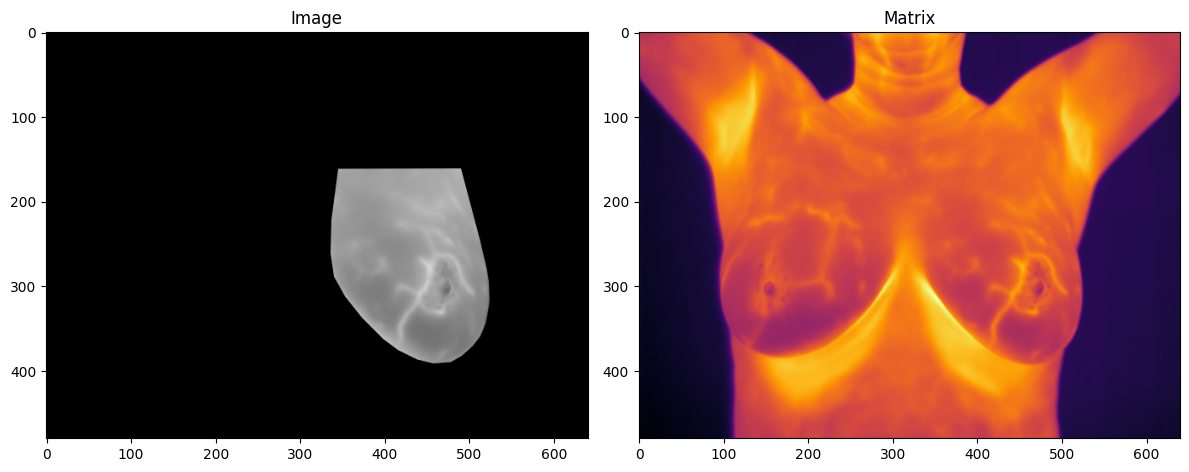

In [48]:
# prompt: plot img_i and arr_i together. they are np.asarray matrices put one next to the other

import matplotlib.pyplot as plt

# Assuming img_i and arr_i are already defined from the previous code

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_i, cmap='inferno')
axes[0].set_title("Image")

axes[1].imshow(arr_i, cmap='inferno') # Use a grayscale colormap for the matrix
axes[1].set_title("Matrix")

plt.tight_layout()
plt.show()


## Create a classification dataset

I am going to use the matrices to create images of thermography and classify them in cancerous and healthy

In [52]:
# prompt: we have two folders inside database. I want to use as train path the path /content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia and as test path the path /content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes. Inside each there are two folders DOENTES which will be cancerous and SAUDÁVEIS which will be healthy classification. Inside each of those folders there are subfolders numbered that are related to patient and inside each patient there are two folders Matrizes and Segmentadas. Matrices has .txt and Segmentadas has .png. Create a code that creates lists for healthy cases and for cancerous cases, each item of the list will be an  image reconstructed by reading the matrices which are txt files
from tqdm import tqdm


def reconstruct_image_from_matrix(matrix_file):
    """Reconstructs an image from a matrix file."""
    arr_i = np.empty((480, 640))
    with open(matrix_file, "r") as f:
        arr = f.readlines()
        for i in range(len(arr)):
            arr[i] = arr[i].replace(",", ".")
            arr_2 = []
            for j in arr[i].split():
                try:
                    arr_2.append(float(j))
                except ValueError:
                    print(f"Warning: Invalid value encountered in line {i+1} of {matrix_file}")
                    arr_2.append(0.0) # Or handle the error differently
            arr_i[i] = np.asarray(arr_2)
    return arr_i


def create_image_datasets(root_path, condition):
    """Creates an image dataset for a specific condition (healthy or cancerous)."""
    image_dataset = []
    for root, _, files in tqdm(os.walk(os.path.join(root_path, condition))):
        for this_file in files:
            if this_file.endswith(".txt"):
                matrix_path = os.path.join(root, this_file)
                try:
                    reconstructed_image = reconstruct_image_from_matrix(matrix_path)
                    image_dataset.append(reconstructed_image)
                except Exception as e:
                    print(f"Error processing {matrix_path}: {e}")
    return image_dataset

# Define paths
train_path = '/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia'
test_path = '/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes'

# Create image datasets
train_healthy_images = create_image_datasets(train_path, 'SAUDÁVEIS')
train_cancerous_images = create_image_datasets(train_path, 'DOENTES')
test_healthy_images = create_image_datasets(test_path, 'SAUDÁVEIS')
test_cancerous_images = create_image_datasets(test_path, 'DOENTES')

print(f"Number of healthy training images: {len(train_healthy_images)}")
print(f"Number of cancerous training images: {len(train_cancerous_images)}")
print(f"Number of healthy testing images: {len(test_healthy_images)}")
print(f"Number of cancerous testing images: {len(test_cancerous_images)}")



49it [00:31,  1.55it/s]
94it [01:03,  1.49it/s]
10it [00:05,  1.77it/s]
19it [00:12,  1.55it/s]

Number of healthy training images: 321
Number of cancerous training images: 627
Number of healthy testing images: 60
Number of cancerous testing images: 120


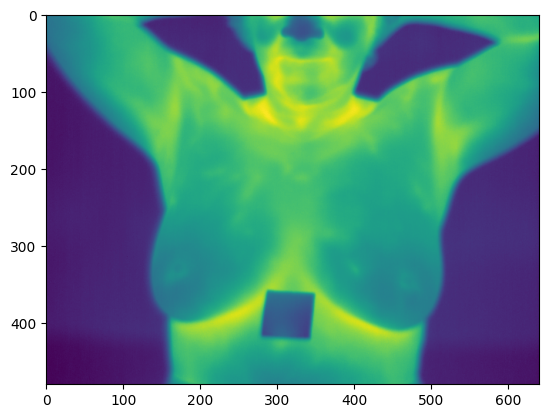

In [57]:
plt.imshow(train_healthy_images[100])

In [58]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [1]:
from datasets import DatasetDict, Features, Value, ClassLabel, Image as hfImage
import numpy as np
from PIL import Image  # Import the Image module from PIL
from sklearn.model_selection import train_test_split

# Function to convert a NumPy array to a PIL Image
def array_to_image(array):
    return Image.fromarray(array.astype(np.uint8))

# Prepare the training data
train_images = train_healthy_images + train_cancerous_images
train_labels = [0] * len(train_healthy_images) + [1] * len(train_cancerous_images)
train_data = [{'image': array_to_image(image), 'label': label} for image, label in zip(train_images, train_labels)]

# Prepare the testing data
test_images = test_healthy_images + test_cancerous_images
test_labels = [0] * len(test_healthy_images) + [1] * len(test_cancerous_images)
test_data = [{'image': array_to_image(image), 'label': label} for image, label in zip(test_images, test_labels)]

# Define features (image and label)
features = Features({
    'image': hfImage(),  # Specify the type of the 'image' data as Pillow Image
    'label': ClassLabel(names=['healthy', 'cancerous']),
})

# Create Hugging Face datasets
train_dataset = DatasetDict.from_list(train_data, features=features)
test_dataset = DatasetDict.from_list(test_data, features=features)

# Combine train and test sets into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
})

# Push to the Hub
dataset.push_to_hub("LeninGF/DMRIR-CL", token="")

NameError: name 'train_healthy_images' is not defined

In [28]:
string = [138,179,180,181,192,198,202,204,209,210,213,240,241,245,249,250,251,255,257,259,261,263,264,270,400,450,500,550,600, 650,700]
print(len(string))
affected_files_text = []
for f in string:
    list1 = []
    normal_dir = "/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/{}/Segmentadas".format(f)
    normal_dir_text = "/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/{}/Matrizes".format(f)
    dir1 = os.path.join(normal_dir,"*.png")
    normal_files = glob.glob(dir1)
    dir2 = os.path.join(normal_dir_text,"*.txt")
    normal_files_text = glob.glob(dir2)

    try:
        for i in range(len(normal_files)):
            list1.append((normal_files[i], normal_files_text[i]))
    except:
        print(f)

    affected_files_text.extend(list1)

string2 = [1000,137,166,220,226,42,49,51,55,66,68,750,800,850,900, 950]

healthy_files_text = []
for f in string2:
    list2 = []
    normal_dir = "/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/SAUDÁVEIS/{}/Segmentadas".format(f)
    normal_dir_text = "/content/database/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/SAUDÁVEIS/{}/Matrizes".format(f)
    dir1 = os.path.join(normal_dir,"*.png")
    normal_files = glob.glob(dir1)
    dir2 = os.path.join(normal_dir_text,"*.txt")
    normal_files_text = glob.glob(dir2)
    # print(len(normal_files),f)
    try:
        for i in range(len(normal_files)):
            list2.append((normal_files[i], normal_files_text[i]))
    except:
        print(f)

    healthy_files_text.extend(list2)


31
181
241


In [29]:
len(affected_files_text), len(healthy_files_text)

(600, 0)

In [31]:
# string = [650,700]
# affected_files_text2 = []
# for f in string:
#     list1 = []
#     normal_dir = "../input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/{}/Segmentadas".format(f)
#     normal_dir_text = "../input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/{}/Matrizes".format(f)
#     dir1 = os.path.join(normal_dir,"*.png")
#     normal_files = glob.glob(dir1)
#     dir2 = os.path.join(normal_dir_text,"*.txt")
#     normal_files_text = glob.glob(dir2)

#     try:
#         for i in range(len(normal_files)):
#             list1.append(normal_files[i]+"|"+normal_files_text[i])
#     except:
#         print(f)

#     affected_files_text2.extend(list1)

# string2 = [950]

# healthy_files_text2 = []
# for f in string2:
#     list2 = []
#     normal_dir = "../input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/{}/Segmentadas".format(f)
#     normal_dir_text = "../input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/SAUDA╠üVEIS/{}/Matrizes".format(f)
#     dir1 = os.path.join(normal_dir,"*.png")
#     normal_files = glob.glob(dir1)
#     dir2 = os.path.join(normal_dir_text,"*.txt")
#     normal_files_text = glob.glob(dir2)
#     #print(len(normal_files),f)
#     try:
#         for i in range(len(normal_files)):
#             list2.append(normal_files[i]+"|"+normal_files_text[i])
#     except:
#         print(f)

#     healthy_files_text2.extend(list2)


In [ ]:
# affected_files_test.extend(affected_files_text2)
# healthy_files_test.extend(healthy_files_text2)

In [32]:
print(len(healthy_files_text))
print(len(affected_files_text))

0
600


In [33]:
# print(len(healthy_files_test))
# print(len(affected_files_test))

In [35]:
train_dic = {}
for f in affected_files_text:
  train_dic[f] = [1,0]
for f in healthy_files_text:
  train_dic[f] = [0,1]


# test_dic = {}
# for f in affected_files_test:
#   test_dic[f] = [1,0]
# for f in healthy_files_test:
#   test_dic[f] = [0,1]

In [36]:
import random
l_train = list(train_dic.items())
random.shuffle(l_train)


# import random
# l_test = list(test_dic.items())
# random.shuffle(l_test)


# #ROBERTS AND SOBEL

In [ ]:
data = []
normal_data = []
labels = []
for i in range(len(l_train)):
    file_name,label = l_train[i]
    a,b = file_name.split("|")
    img = cv2.imread(a)
    arr_1 = np.empty((480,640))

    try:
        with open(b,"r") as f:
            arr = f.readlines()
            for i in range(len(arr)):
                arr[i] = arr[i].replace(",", ".")
                arr_2 = []
                for j in arr[i].split():
                    arr_2.append(float(j))
                arr_1[i] = np.asarray(arr_2)
        img = np.asarray(img)
        arr_1 = np.asarray(arr_1)
        edge_roberts = roberts(arr_1)
        edge_sobel = sobel(arr_1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
        arr_img = cv2.resize(arr_1,(224,224),interpolation = cv2.INTER_CUBIC)
        r_img = cv2.resize(edge_roberts,(224,224),interpolation = cv2.INTER_CUBIC)
        s_img = cv2.resize(edge_sobel,(224,224),interpolation = cv2.INTER_CUBIC)
        arr_3 = np.expand_dims(arr_img,axis = -1)
        arr_2 = np.expand_dims(r_img,axis = -1)
        arr_1 = np.expand_dims(s_img,axis = -1)
        img2 = np.concatenate((arr_3,arr_2,arr_1),axis = -1)
        height, width = img.shape[:2]
        img2 = img2.astype('float32')/255.0
        img = img.astype('float32')/255.0
        data.append(img2)
        normal_data.append(img)
        labels.append(label)

    except:
        print(i,file_name)
        print("Not possible")
train_data = np.array(data)
print(train_data.shape)
normal_data = np.array(normal_data)
print(normal_data.shape)

train_labels = np.array(labels)
print(train_labels.shape)

print('^_^-training data finished-^_^')

In [ ]:
test_text = []
data = []
labels = []
for i in range(len(l_test)):
    file_name,label = l_test[i]
    a,b = file_name.split("|")
    img = cv2.imread(a)
    arr_1 = np.empty((480,640))
    try:
        with open(b,"r") as f:
            arr = f.readlines()
            for i in range(len(arr)):
                arr_2 = []
                for j in arr[i].split():
                    arr_2.append(float(j))
                arr_1[i] = np.asarray(arr_2)
        img = np.asarray(img)
        arr_1 = np.asarray(arr_1)
        edge_roberts = roberts(arr_1)
        edge_sobel = sobel(arr_1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_AREA)
        arr_img = cv2.resize(arr_1,(224,224),interpolation = cv2.INTER_CUBIC)
        s_img = cv2.resize(edge_roberts,(224,224),interpolation = cv2.INTER_CUBIC)
        r_img = cv2.resize(edge_sobel,(224,224),interpolation = cv2.INTER_CUBIC)
        arr_3 = np.expand_dims(arr_img,axis = -1)
        arr_2 = np.expand_dims(r_img,axis = -1)
        arr_1 = np.expand_dims(s_img,axis = -1)
        img2 = np.concatenate((arr_3,arr_2,arr_1),axis = -1)
        height, width = img.shape[:2]
        img2 = img2.astype('float32')/255.0
        img = img.astype('float32')/255.0
        test_text.append(img2)
        data.append(img)
        labels.append(label)

    except:
        print(i,file_name)
        print("Not possible")


test_data = np.array(data)
print(test_data.shape)
test_text = np.array(test_text)
print(test_text.shape)
test_labels = np.array(labels)
print(test_labels.shape)

print('^_^-testing data finished-^_^')

# **#CANNY AND roberts**

In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean
data = []
normal_data = []
labels = []
for i in range(len(l_train)):
    file_name,label = l_train[i]
    a,b = file_name.split("|")
    img = cv2.imread(a)
    arr_1 = np.empty((480,640))

    try:
        with open(b,"r") as f:
            arr = f.readlines()
            for i in range(len(arr)):
                arr[i] = arr[i].replace(",", ".")
                arr_2 = []
                for j in arr[i].split():
                    arr_2.append(float(j))
                arr_1[i] = np.asarray(arr_2)
        img = np.asarray(img)
        arr_1 = np.asarray(arr_1)
        edge_roberts = roberts(arr_1)
        edge_canny = feature.canny(arr_1, sigma=1)
        edge_canny = np.asarray(edge_canny)

        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
        arr_img = cv2.resize(arr_1,(224,224),interpolation = cv2.INTER_CUBIC)
        r_img = cv2.resize(edge_roberts,(224,224),interpolation = cv2.INTER_CUBIC)
        s_img = resize(edge_canny, (224,224),anti_aliasing=True)
        #s_img = cv2.resize(edge_canny,(224,224),interpolation = cv2.INTER_CUBIC)

        arr_3 = np.expand_dims(arr_img,axis = -1)
        arr_2 = np.expand_dims(r_img,axis = -1)
        arr_1 = np.expand_dims(s_img,axis = -1)
        img2 = np.concatenate((arr_3,arr_2,arr_1),axis = -1)
        height, width = img.shape[:2]
        img2 = img2.astype('float32')/255.0
        img = img.astype('float32')/255.0
        data.append(img2)
        normal_data.append(img)
        labels.append(label)

    except:
        print(i,file_name)
        print("Not possible")
train_data = np.array(data)
print(train_data.shape)
normal_data = np.array(normal_data)
print(normal_data.shape)

train_labels = np.array(labels)
print(train_labels.shape)

print('^_^-training data finished-^_^')

In [ ]:
test_text = []
data = []
labels = []
for i in range(len(l_test)):
    file_name,label = l_test[i]
    a,b = file_name.split("|")
    img = cv2.imread(a)
    arr_1 = np.empty((480,640))
    try:
        with open(b,"r") as f:
            arr = f.readlines()
            for i in range(len(arr)):
                arr_2 = []
                for j in arr[i].split():
                    arr_2.append(float(j))
                arr_1[i] = np.asarray(arr_2)
        img = np.asarray(img)
        arr_1 = np.asarray(arr_1)
        edge_roberts = roberts(arr_1)
        edge_canny = feature.canny(arr_1, sigma=1)
        edge_canny = np.asarray(edge_canny)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_AREA)
        arr_img = cv2.resize(arr_1,(224,224),interpolation = cv2.INTER_CUBIC)
        s_img = cv2.resize(edge_roberts,(224,224),interpolation = cv2.INTER_CUBIC)
        r_img = resize(edge_canny, (224,224),anti_aliasing=True)
        #r_img = cv2.resize(edge_canny,(224,224),interpolation = cv2.INTER_CUBIC)
        arr_3 = np.expand_dims(arr_img,axis = -1)
        arr_2 = np.expand_dims(r_img,axis = -1)
        arr_1 = np.expand_dims(s_img,axis = -1)
        img2 = np.concatenate((arr_3,arr_2,arr_1),axis = -1)
        height, width = img.shape[:2]
        img2 = img2.astype('float32')/255.0
        img = img.astype('float32')/255.0
        test_text.append(img2)
        data.append(img)
        labels.append(label)

    except:
        print(i,file_name)
        print("Not possible")


test_data = np.array(data)
print(test_data.shape)
test_text = np.array(test_text)
print(test_text.shape)
test_labels = np.array(labels)
print(test_labels.shape)

print('^_^-testing data finished-^_^')

# **#CANNY AND prewitt**

In [ ]:
data = []
normal_data = []
labels = []
for i in range(len(l_train)):
    file_name,label = l_train[i]
    a,b = file_name.split("|")
    img = cv2.imread(a)
    arr_1 = np.empty((480,640))

    try:
        with open(b,"r") as f:
            arr = f.readlines()
            for i in range(len(arr)):
                arr[i] = arr[i].replace(",", ".")
                arr_2 = []
                for j in arr[i].split():
                    arr_2.append(float(j))
                arr_1[i] = np.asarray(arr_2)
        img = np.asarray(img)
        arr_1 = np.asarray(arr_1)
        edge_prewitt = prewitt(arr_1)
        edge_canny = feature.canny(arr_1, sigma=1)
        edge_canny = np.asarray(edge_canny)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
        arr_img = cv2.resize(arr_1,(224,224),interpolation = cv2.INTER_CUBIC)
        r_img = cv2.resize(edge_prewitt,(224,224),interpolation = cv2.INTER_CUBIC)
        #s_img = cv2.resize(edge_canny,(224,224),interpolation = cv2.INTER_CUBIC)
        s_img = resize(edge_canny, (224,224),anti_aliasing=True)
        arr_3 = np.expand_dims(arr_img,axis = -1)
        arr_2 = np.expand_dims(r_img,axis = -1)
        arr_1 = np.expand_dims(s_img,axis = -1)
        img2 = np.concatenate((arr_3,arr_2,arr_1),axis = -1)
        height, width = img.shape[:2]
        img2 = img2.astype('float32')/255.0
        img = img.astype('float32')/255.0
        data.append(img2)
        normal_data.append(img)
        labels.append(label)

    except:
        print(i,file_name)
        print("Not possible")
train_data = np.array(data)
print(train_data.shape)
normal_data = np.array(normal_data)
print(normal_data.shape)

train_labels = np.array(labels)
print(train_labels.shape)

print('^_^-training data finished-^_^')

In [ ]:
test_text = []
data = []
labels = []
for i in range(len(l_test)):
    file_name,label = l_test[i]
    a,b = file_name.split("|")
    img = cv2.imread(a)
    arr_1 = np.empty((480,640))
    try:
        with open(b,"r") as f:
            arr = f.readlines()
            for i in range(len(arr)):
                arr_2 = []
                for j in arr[i].split():
                    arr_2.append(float(j))
                arr_1[i] = np.asarray(arr_2)
        img = np.asarray(img)
        arr_1 = np.asarray(arr_1)
        edge_prewitt = prewitt(arr_1)
        edge_canny = feature.canny(arr_1, sigma=1)
        edge_canny = np.asarray(edge_canny)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_AREA)
        arr_img = cv2.resize(arr_1,(224,224),interpolation = cv2.INTER_CUBIC)
        s_img = cv2.resize(edge_prewitt,(224,224),interpolation = cv2.INTER_CUBIC)
        #r_img = cv2.resize(edge_canny,(224,224),interpolation = cv2.INTER_CUBIC)
        r_img = resize(edge_canny, (224,224),anti_aliasing=True)
        arr_3 = np.expand_dims(arr_img,axis = -1)
        arr_2 = np.expand_dims(r_img,axis = -1)
        arr_1 = np.expand_dims(s_img,axis = -1)
        img2 = np.concatenate((arr_3,arr_2,arr_1),axis = -1)
        height, width = img.shape[:2]
        img2 = img2.astype('float32')/255.0
        img = img.astype('float32')/255.0
        test_text.append(img2)
        data.append(img)
        labels.append(label)

    except:
        print(i,file_name)
        print("Not possible")


test_data = np.array(data)
print(test_data.shape)
test_text = np.array(test_text)
print(test_text.shape)
test_labels = np.array(labels)
print(test_labels.shape)

print('^_^-testing data finished-^_^')

# **Training Model**

In [ ]:
in_model = tf.keras.applications.DenseNet121(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',classes = 2)

in_model.trainable = False
inputs = tf.keras.Input(shape=(224,224,3))


x = in_model(inputs)
flat = Flatten()(x)

dense_1 = Dense(4096,activation = 'relu')(flat)

dense_2 = Dense(4096,activation = 'relu')(dense_1)

prediction = Dense(2,activation = 'softmax')(dense_2)

in_pred = Model(inputs = inputs,outputs = prediction)

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
in_pred.summary()
in_pred.compile(optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0002), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy'])
in_pred.fit(train_data,train_labels,batch_size = 32,epochs = 50)

In [ ]:
in_pred.evaluate(test_data,test_labels)

8/8 [==============================] - 0s 56ms/step - loss: 8.5441 - accuracy: 0.4647


[8.544113159179688, 0.46473029255867004]

In [ ]:
test_ = in_pred.predict(test_text)
Y_pred= np.argmax(test_labels, axis=1)
vgg19 = np.argmax(test_, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(Y_pred,vgg19))
print(classification_report(Y_pred,vgg19))
print(accuracy_score(Y_pred,vgg19))